In [46]:
import pickle
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import BertTokenizer, BertModel, BertForSequenceClassification, AdamW
from transformers.optimization import get_constant_schedule_with_warmup
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm
import matplotlib.pyplot as plt
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

print("DONE!!!")

DONE!!!


In [47]:
print("Datasets......\n1. SNLI \n2. MULTI-NLI\n3. SICK")
for i in range(3):
    dataset_choice = int(input("Enter choice :"))
    if dataset_choice == 1:
        dataset = load_dataset("snli")
        break
    elif dataset_choice == 2:
        dataset = load_dataset("multi_nli")
        break
    elif dataset_choice == 3:
        dataset =  load_dataset("sick")
        break
else:
    print("Invalid Choices Thrice....\nRun the program again")
    exit()

Datasets......
1. SNLI 
2. MULTI-NLI
3. SICK


Enter choice : 2


In [48]:
class NLIDataset(Dataset):
    def __init__(self, data):
        self.data = data
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        item = self.data.iloc[idx]
        return {
            'premise': item['premise'],
            'hypothesis': item['hypothesis'],
            'label': item['label']
        }

print("DONE!!!")

DONE!!!


In [49]:
print(dataset_choice, end = "-")

if dataset_choice == 1:
    print("SNLI")
    dataset['train'] = dataset['train'].filter(lambda sen: sen['label'] != -1)
    dataset['validation'] = dataset['validation'].filter(lambda sen: sen['label'] != -1)
    dataset['test'] = dataset['test'].filter(lambda sen: sen['label'] != -1)
    train_data = dataset['train']
    test_data = dataset['test']
    validation_data = dataset['validation']

    train_dataset = pd.DataFrame({
        'sNo': range(len(train_data)),
        'premise': train_data['premise'],
        'hypothesis': train_data['hypothesis'],
        'label': train_data['label']
    })

    val_dataset = pd.DataFrame({
        'sNo': range(len(validation_data)),
        'premise': validation_data['premise'],
        'hypothesis': validation_data['hypothesis'],
        'label': validation_data['label']
    })

    test_dataset = pd.DataFrame({
        'sNo': range(len(test_data)), 
        'premise': test_data['premise'],
        'hypothesis': test_data['hypothesis'],
        'label': test_data['label']
    })
    
elif dataset_choice == 2:
    print("MULTI-NLI")
    train_data = dataset['train']
    validation_data = dataset['validation_matched']
    test_data = dataset['validation_mismatched']

    train_dataset = pd.DataFrame({
        'sNo': range(len(train_data)),
        'premise': train_data['premise'],
        'hypothesis': train_data['hypothesis'],
        'label': train_data['label']
    })

    val_dataset = pd.DataFrame({
        'sNo': range(len(validation_data)),  
        'premise': validation_data['premise'],
        'hypothesis': validation_data['hypothesis'],
        'label': validation_data['label']
    })

    test_dataset = pd.DataFrame({
        'sNo': range(len(test_data)),  
        'premise': test_data['premise'],
        'hypothesis': test_data['hypothesis'],
        'label': test_data['label']
    })
    
elif dataset_choice == 3:
    print("SICK")
    train_data = dataset['train']
    validation_data = dataset['validation']
    test_data = dataset['test']

    train_dataset = pd.DataFrame({
        'sNo': range(len(train_data)),
        'premise': train_data['sentence_A'],
        'hypothesis': train_data['sentence_B'],
        'label': train_data['label']
    })

    val_dataset = pd.DataFrame({
        'sNo': range(len(validation_data)),
        'premise': validation_data['sentence_A'],
        'hypothesis': validation_data['sentence_B'],
        'label': validation_data['label']
    })

    test_dataset = pd.DataFrame({
        'sNo': range(len(test_data)), 
        'premise': test_data['sentence_A'],
        'hypothesis': test_data['sentence_B'],
        'label': test_data['label']
    })

print("DONE!!!")

2-MULTI-NLI
DONE!!!


In [67]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model1 = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)
optimizer = AdamW(model1.parameters(), lr=1e-5)

print(dataset_choice)
# Datasets......
train_ds = NLIDataset(train_dataset[:50000])
val_ds = NLIDataset(val_dataset)
test_ds = NLIDataset(test_dataset)

# DataLoaders......
batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size)
test_loader = DataLoader(test_ds, batch_size=batch_size)
print(len(train_loader), len(val_loader), len(test_loader))
print("DONE!!!")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


2
1563 307 308
DONE!!!


In [51]:
train_ds[1]

{'premise': 'you know during the season and i guess at at your level uh you lose them to the next level if if they decide to recall the the parent team the Braves decide to call to recall a guy from triple A then a double A guy goes up to replace him and a single A guy goes up to replace him',
 'hypothesis': 'You lose the things to the following level if the people recall.',
 'label': 0}

# **BERT**

In [52]:
from collections import Counter

label_counts = Counter(train_dataset['label'])

print("Count of unique labels:")
for label, count in label_counts.items():
    print(f"Label {label}: {count} samples")

Count of unique labels:
Label 1: 130900 samples
Label 0: 130899 samples
Label 2: 130903 samples


In [53]:
print("Train Dataset Size:", len(train_dataset), len(train_ds))
print("Val Dataset Size:", len(val_dataset), len(val_ds))
print("Test Dataset Size:", len(test_dataset), len(test_ds))

print("Train DataLoader Size:", len(train_loader))
print("Val DataLoader Size:", len(val_loader))
print("Test DataLoader Size:", len(test_loader))

Train Dataset Size: 392702 100000
Val Dataset Size: 9815 9815
Test Dataset Size: 9832 9832
Train DataLoader Size: 3125
Val DataLoader Size: 307
Test DataLoader Size: 308


In [54]:
epochs = 3

In [55]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model1.to(device)
all_preds1 = []

for epoch in range(epochs): 
    print(epoch + 1, "Epoch.......")
    correct_predictions = 0
    total_predictions = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}"):  
        optimizer.zero_grad()
        inputs = tokenizer(batch['premise'], batch['hypothesis'], padding=True, truncation=True, return_tensors="pt")
        inputs = {key: tensor.to(device) for key, tensor in inputs.items()}  
        labels = batch['label'].to(device)
        
        outputs = model1(**inputs)
        logits = outputs.logits
        
        loss = F.cross_entropy(logits, labels)
        loss.backward()
        optimizer.step()
        
        predicted_labels = torch.argmax(logits, dim=1)
        correct_predictions += torch.sum(predicted_labels == labels).item()
        total_predictions += labels.size(0)
    
    train_accuracy = correct_predictions / total_predictions
    print("Train Accuracy:", train_accuracy)
    
    # Validation...
    model1.eval()
    val_labels = []
    val_preds = []
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validation"):
            inputs = tokenizer(batch['premise'], batch['hypothesis'], padding=True, truncation=True, return_tensors="pt")
            inputs = {key: tensor.to(device) for key, tensor in inputs.items()}
            labels = batch['label'].to(device)
            outputs = model1(**inputs)
            val_labels.extend(labels.cpu().numpy())
            val_preds.extend(outputs.logits.argmax(dim=-1).cpu().numpy())

    val_accuracy = accuracy_score(val_labels, val_preds)
    print("Validation Accuracy:", val_accuracy)
    
    test_labels = []
    test_preds2 = []
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing"):  
            inputs = tokenizer(batch['premise'], batch['hypothesis'], padding=True, truncation=True, return_tensors="pt")
            inputs = {key: tensor.to(device) for key, tensor in inputs.items()}  
            labels = batch['label'].to(device)
            outputs = model1(**inputs)
            test_labels.extend(labels.cpu().numpy())
            test_preds2.extend(outputs.logits.argmax(dim=-1).cpu().numpy())

    test_accuracy = accuracy_score(test_labels, test_preds2)
    all_preds1.append(test_preds2)
    print("Bert Test Accuracy:", test_accuracy)
    print()

cuda
1 Epoch.......


Epoch 1: 100%|██████████| 3125/3125 [17:02<00:00,  3.06it/s]


Train Accuracy: 0.74941


Validation: 100%|██████████| 307/307 [00:41<00:00,  7.32it/s]


Validation Accuracy: 0.7942944472745798


Testing: 100%|██████████| 308/308 [00:43<00:00,  7.08it/s]


Bert Test Accuracy: 0.7995321399511798

2 Epoch.......


Epoch 2: 100%|██████████| 3125/3125 [17:05<00:00,  3.05it/s]


Train Accuracy: 0.87857


Validation: 100%|██████████| 307/307 [00:41<00:00,  7.42it/s]


Validation Accuracy: 0.801018848700968


Testing: 100%|██████████| 308/308 [00:42<00:00,  7.19it/s]


Bert Test Accuracy: 0.8004475183075671

3 Epoch.......


Epoch 3: 100%|██████████| 3125/3125 [16:59<00:00,  3.06it/s]


Train Accuracy: 0.95881


Validation: 100%|██████████| 307/307 [00:41<00:00,  7.38it/s]


Validation Accuracy: 0.7867549668874172


Testing: 100%|██████████| 308/308 [00:43<00:00,  7.14it/s]

Bert Test Accuracy: 0.7899715215622457



In [56]:
# Testing.......
test_labels = []
test_preds1 = []
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing"):  
        inputs = tokenizer(batch['premise'], batch['hypothesis'], padding=True, truncation=True, return_tensors="pt")
        inputs = {key: tensor.to(device) for key, tensor in inputs.items()}  
        labels = batch['label'].to(device)
        outputs = model1(**inputs)
        test_labels.extend(labels.cpu().numpy())
        test_preds1.extend(outputs.logits.argmax(dim=-1).cpu().numpy())

test_accuracy = accuracy_score(test_labels, test_preds1)
print("BERT Base Test Accuracy:", test_accuracy)

Testing: 100%|██████████| 308/308 [00:43<00:00,  7.16it/s]

BERT Base Test Accuracy: 0.7899715215622457


In [57]:
combined_preds = np.vstack(all_preds1)
majority_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x)), axis=0, arr=combined_preds)
test_accuracy = accuracy_score(test_labels, majority_vote)
print("BERT Avg Test Accuracy:", test_accuracy)

BERT Avg Test Accuracy: 0.8064483319772172


# **RoBERTa**

In [58]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW
from torch.utils.data import DataLoader
from tqdm import tqdm
from datasets import load_dataset
from sklearn.metrics import accuracy_score

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model2 = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=3)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2.to(device)

optimizer = AdamW(model2.parameters(), lr=1e-5)
all_preds2 = []

for epoch in range(epochs): 
    print(epoch + 1, "Epoch.......")
    correct_predictions = 0
    total_predictions = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}"):  
        optimizer.zero_grad()
        inputs = tokenizer(batch['premise'], batch['hypothesis'], padding=True, truncation=True, return_tensors="pt").to(device)
        labels = batch['label'].to(device)
        
        outputs = model2(**inputs)
        logits = outputs.logits
        
        loss = F.cross_entropy(logits, labels)
        loss.backward()
        optimizer.step()
        
        predicted_labels = torch.argmax(logits, dim=1)
        correct_predictions += torch.sum(predicted_labels == labels).item()
        total_predictions += labels.size(0)
    
    train_accuracy = correct_predictions / total_predictions
    print("Train Accuracy:", train_accuracy)
    
    # Validation
    model2.eval()
    val_labels = []
    val_preds = []
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validation"):
            inputs = tokenizer(batch['premise'], batch['hypothesis'], padding=True, truncation=True, return_tensors="pt").to(device)
            labels = batch['label'].to(device)
            outputs = model2(**inputs)
            val_labels.extend(labels.cpu().numpy())
            val_preds.extend(outputs.logits.argmax(dim=-1).cpu().numpy())

    val_accuracy = accuracy_score(val_labels, val_preds)
    print("Validation Accuracy:", val_accuracy)
    
    test_labels = []
    test_preds2 = []
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing"):  
            inputs = tokenizer(batch['premise'], batch['hypothesis'], padding=True, truncation=True, return_tensors="pt")
            inputs = {key: tensor.to(device) for key, tensor in inputs.items()}  
            labels = batch['label'].to(device)
            outputs = model2(**inputs)
            test_labels.extend(labels.cpu().numpy())
            test_preds2.extend(outputs.logits.argmax(dim=-1).cpu().numpy())

    test_accuracy = accuracy_score(test_labels, test_preds2)
    all_preds2.append(test_preds2)
    print("Roberta Test Accuracy:", test_accuracy)
    print()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


1 Epoch.......


Validation: 100%|██████████| 307/307 [00:32<00:00,  9.36it/s]


Validation Accuracy: 0.8426897605705552


Testing: 100%|██████████| 308/308 [00:34<00:00,  9.00it/s]


Roberta Test Accuracy: 0.8449959316517494

2 Epoch.......


Epoch 2: 100%|██████████| 3125/3125 [15:30<00:00,  3.36it/s]


Train Accuracy: 0.90395


Validation: 100%|██████████| 307/307 [00:32<00:00,  9.38it/s]


Validation Accuracy: 0.8402445236882323


Testing: 100%|██████████| 308/308 [00:34<00:00,  9.05it/s]


Roberta Test Accuracy: 0.8457078925956062

3 Epoch.......


Epoch 3: 100%|██████████| 3125/3125 [15:30<00:00,  3.36it/s]


Train Accuracy: 0.96176


Validation: 100%|██████████| 307/307 [00:32<00:00,  9.41it/s]


Validation Accuracy: 0.8380030565461029


Testing: 100%|██████████| 308/308 [00:33<00:00,  9.06it/s]

Roberta Test Accuracy: 0.842860048820179



In [59]:
# Testing.......
test_labels = []
test_preds2 = []
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing"):  
        inputs = tokenizer(batch['premise'], batch['hypothesis'], padding=True, truncation=True, return_tensors="pt")
        inputs = {key: tensor.to(device) for key, tensor in inputs.items()}  
        labels = batch['label'].to(device)
        outputs = model2(**inputs)
        test_labels.extend(labels.cpu().numpy())
        test_preds2.extend(outputs.logits.argmax(dim=-1).cpu().numpy())

test_accuracy = accuracy_score(test_labels, test_preds2)
print("Roberta Test Accuracy:", test_accuracy)

Testing: 100%|██████████| 308/308 [00:34<00:00,  9.03it/s]

Roberta Test Accuracy: 0.842860048820179


In [60]:
combined_preds = np.vstack(all_preds2)
majority_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x)), axis=0, arr=combined_preds)
test_accuracy = accuracy_score(test_labels, majority_vote)
print("Roberta Avg Test Accuracy:", test_accuracy)

Roberta Avg Test Accuracy: 0.8525223759153784


# **ALBERT**

In [68]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AlbertTokenizer, AlbertForSequenceClassification, AdamW
from torch.utils.data import DataLoader
from tqdm import tqdm
from datasets import load_dataset
from sklearn.metrics import accuracy_score

tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')
model3 = AlbertForSequenceClassification.from_pretrained("albert-base-v2", num_labels=3)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model3.to(device)

optimizer = AdamW(model3.parameters(), lr=1e-5)
all_preds3 = []

for epoch in range(epochs): 
    print(epoch + 1, "Epoch.......")
    correct_predictions = 0
    total_predictions = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}"):  
        optimizer.zero_grad()
        inputs = tokenizer(batch['premise'], batch['hypothesis'], padding=True, truncation=True, return_tensors="pt").to(device)
        labels = batch['label'].to(device)
        
        outputs = model3(**inputs)
        logits = outputs.logits
        
        loss = F.cross_entropy(logits, labels)
        loss.backward()
        optimizer.step()
        
        predicted_labels = torch.argmax(logits, dim=1)
        correct_predictions += torch.sum(predicted_labels == labels).item()
        total_predictions += labels.size(0)
    
    train_accuracy = correct_predictions / total_predictions
    print("Train Accuracy:", train_accuracy)
    
    # Validation
    model3.eval()
    val_labels = []
    val_preds = []
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validation"):
            inputs = tokenizer(batch['premise'], batch['hypothesis'], padding=True, truncation=True, return_tensors="pt").to(device)
            labels = batch['label'].to(device)
            outputs = model3(**inputs)
            val_labels.extend(labels.cpu().numpy())
            val_preds.extend(outputs.logits.argmax(dim=-1).cpu().numpy())

    val_accuracy = accuracy_score(val_labels, val_preds)
    print("Validation Accuracy:", val_accuracy)
    
    test_labels = []
    test_preds2 = []
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing"):  
            inputs = tokenizer(batch['premise'], batch['hypothesis'], padding=True, truncation=True, return_tensors="pt")
            inputs = {key: tensor.to(device) for key, tensor in inputs.items()}  
            labels = batch['label'].to(device)
            outputs = model3(**inputs)
            test_labels.extend(labels.cpu().numpy())
            test_preds2.extend(outputs.logits.argmax(dim=-1).cpu().numpy())

    test_accuracy = accuracy_score(test_labels, test_preds2)
    all_preds3.append(test_preds2)
    print("Alberta Test Accuracy:", test_accuracy)
    print()

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


1 Epoch.......


Epoch 1: 100%|██████████| 1563/1563 [08:25<00:00,  3.09it/s]


Train Accuracy: 0.7481


Validation: 100%|██████████| 307/307 [00:38<00:00,  7.91it/s]


Validation Accuracy: 0.7937850229240958


Testing: 100%|██████████| 308/308 [00:40<00:00,  7.69it/s]


Alberta Test Accuracy: 0.8119406021155411

2 Epoch.......


Epoch 2: 100%|██████████| 1563/1563 [08:29<00:00,  3.07it/s]


Train Accuracy: 0.8449


Validation: 100%|██████████| 307/307 [00:39<00:00,  7.68it/s]


Validation Accuracy: 0.8072338257768721


Testing: 100%|██████████| 308/308 [00:41<00:00,  7.46it/s]


Alberta Test Accuracy: 0.8231285598047193

3 Epoch.......


Epoch 3: 100%|██████████| 1563/1563 [08:29<00:00,  3.07it/s]


Train Accuracy: 0.89906


Validation: 100%|██████████| 307/307 [00:38<00:00,  7.94it/s]


Validation Accuracy: 0.7983698420784513


Testing: 100%|██████████| 308/308 [00:40<00:00,  7.70it/s]

Alberta Test Accuracy: 0.8120423108218063



In [69]:
# Testing.......
test_labels = []
test_preds3 = []
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing"):  
        inputs = tokenizer(batch['premise'], batch['hypothesis'], padding=True, truncation=True, return_tensors="pt")
        inputs = {key: tensor.to(device) for key, tensor in inputs.items()}  
        labels = batch['label'].to(device)
        outputs = model3(**inputs)
        test_labels.extend(labels.cpu().numpy())
        test_preds3.extend(outputs.logits.argmax(dim=-1).cpu().numpy())

test_accuracy = accuracy_score(test_labels, test_preds3)
print("Alberta Test Accuracy:", test_accuracy)

Testing: 100%|██████████| 308/308 [00:39<00:00,  7.72it/s]

Alberta Test Accuracy: 0.8120423108218063


In [70]:
combined_preds = np.vstack(all_preds3)
majority_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x)), axis=0, arr=combined_preds)
test_accuracy = accuracy_score(test_labels, majority_vote)
print("Alberta Avg Test Accuracy:", test_accuracy)

Alberta Avg Test Accuracy: 0.8248576078112286


# **Results**

In [71]:
print("Bert + Roberta + Alberta")
combined_preds = np.vstack([all_preds1[:-1], all_preds2[:-1], all_preds3[:-1]])
majority_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x)), axis=0, arr=combined_preds)
test_preds = majority_vote.tolist()

test_accuracy = accuracy_score(test_labels, test_preds)
print("Ensemble Test Accuracy :", test_accuracy)

combined_preds = np.vstack([all_preds1, all_preds2, all_preds3])
majority_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x)), axis=0, arr=combined_preds)
test_preds = majority_vote.tolist()

test_accuracy = accuracy_score(test_labels, test_preds)
print("Ensemble + Average Test Accuracy :", test_accuracy)

Bert + Roberta + Alberta
Ensemble Test Accuracy : 0.8486574450772986
Ensemble + Average Test Accuracy : 0.852013832384052


In [72]:
print("Roberta + Alberta")
combined_preds = np.vstack([all_preds2[:-1], all_preds3[:-1]])
majority_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x)), axis=0, arr=combined_preds)
test_preds = majority_vote.tolist()

test_accuracy = accuracy_score(test_labels, test_preds)
print("Ensemble Test Accuracy :", test_accuracy)

combined_preds = np.vstack([all_preds2, all_preds3])
majority_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x)), axis=0, arr=combined_preds)
test_preds = majority_vote.tolist()

test_accuracy = accuracy_score(test_labels, test_preds)
print("Ensemble + Average Test Accuracy :", test_accuracy)

Roberta + Alberta
Ensemble Test Accuracy : 0.8496745321399511
Ensemble + Average Test Accuracy : 0.8541497152156224


In [73]:
print("Bert + Roberta")
combined_preds = np.vstack([all_preds1[:-1], all_preds2[:-1]])
majority_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x)), axis=0, arr=combined_preds)
test_preds = majority_vote.tolist()

test_accuracy = accuracy_score(test_labels, test_preds)
print("Ensemble Test Accuracy :", test_accuracy)

combined_preds = np.vstack([all_preds1, all_preds2])
majority_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x)), axis=0, arr=combined_preds)
test_preds = majority_vote.tolist()

test_accuracy = accuracy_score(test_labels, test_preds)
print("Ensemble + Average Test Accuracy :", test_accuracy)

Bert + Roberta
Ensemble Test Accuracy : 0.8407241659886087
Ensemble + Average Test Accuracy : 0.8501830756712775


In [74]:
print("Bert + Alberta")
combined_preds = np.vstack([all_preds1[:-1], all_preds3[:-1]])
majority_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x)), axis=0, arr=combined_preds)
test_preds = majority_vote.tolist()

test_accuracy = accuracy_score(test_labels, test_preds)
print("Ensemble Test Accuracy :", test_accuracy)

combined_preds = np.vstack([all_preds1, all_preds3])
majority_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x)), axis=0, arr=combined_preds)
test_preds = majority_vote.tolist()

test_accuracy = accuracy_score(test_labels, test_preds)
print("Ensemble + Average Test Accuracy :", test_accuracy)

Bert + Alberta
Ensemble Test Accuracy : 0.8282139951179821
Ensemble + Average Test Accuracy : 0.8350284784377543


# **Ensemble**

Bert + Roberta + Alberta
Ensemble Test Accuracy : 84.87%
Ensemble F1 Score : 84.83%
Ensemble Recall Score : 84.87%
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.89      0.87      3463
           1       0.82      0.79      0.81      3129
           2       0.86      0.86      0.86      3240

    accuracy                           0.85      9832
   macro avg       0.85      0.85      0.85      9832
weighted avg       0.85      0.85      0.85      9832



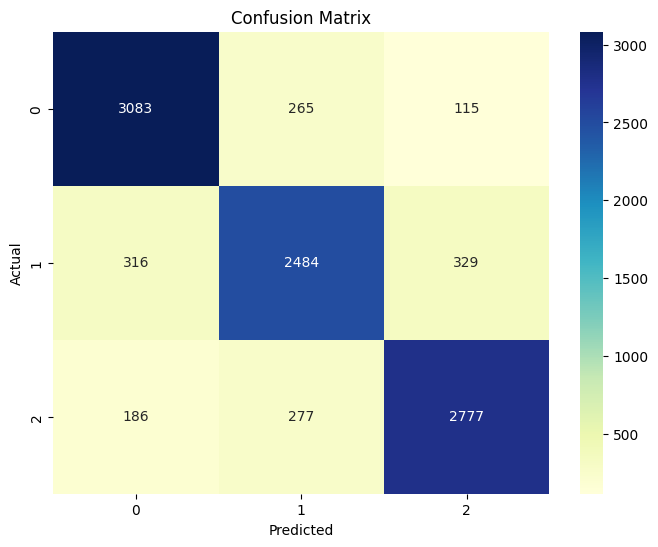

In [75]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix

print("Bert + Roberta + Alberta")
combined_preds = np.vstack([all_preds1[:-1], all_preds2[:-1], all_preds3[:-1]])
majority_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x)), axis=0, arr=combined_preds)
test_preds = majority_vote.tolist()

# Accuracy
test_accuracy = accuracy_score(test_labels, test_preds)
print("Ensemble Test Accuracy : {:.2f}%".format(test_accuracy * 100))

# F1 Score
f1 = f1_score(test_labels, test_preds, average='weighted')
print("Ensemble F1 Score : {:.2f}%".format(f1 * 100))

# Recall
recall = recall_score(test_labels, test_preds, average='weighted')
print("Ensemble Recall Score : {:.2f}%".format(recall * 100))

# Classification Report
print("Classification Report:")
print(classification_report(test_labels, test_preds))

# Confusion matrix
conf_matrix = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGnBu', xticklabels=np.unique(test_labels), yticklabels=np.unique(test_labels))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


Roberta + Alberta
Ensemble Test Accuracy : 84.97%
Ensemble F1 Score : 84.95%
Ensemble Recall Score : 84.97%
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.90      0.88      3463
           1       0.81      0.80      0.81      3129
           2       0.88      0.84      0.86      3240

    accuracy                           0.85      9832
   macro avg       0.85      0.85      0.85      9832
weighted avg       0.85      0.85      0.85      9832



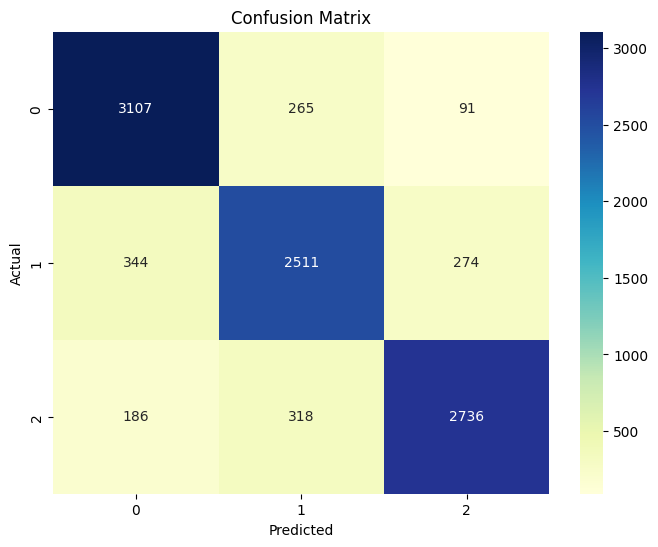

In [76]:
print("Roberta + Alberta")
combined_preds = np.vstack([all_preds2[:-1], all_preds3[:-1]])
majority_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x)), axis=0, arr=combined_preds)
test_preds = majority_vote.tolist()

# Accuracy
test_accuracy = accuracy_score(test_labels, test_preds)
print("Ensemble Test Accuracy : {:.2f}%".format(test_accuracy * 100))

# F1 Score
f1 = f1_score(test_labels, test_preds, average='weighted')
print("Ensemble F1 Score : {:.2f}%".format(f1 * 100))

# Recall
recall = recall_score(test_labels, test_preds, average='weighted')
print("Ensemble Recall Score : {:.2f}%".format(recall * 100))

# Classification Report
print("Classification Report:")
print(classification_report(test_labels, test_preds))

# Confusion matrix
conf_matrix = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGnBu', xticklabels=np.unique(test_labels), yticklabels=np.unique(test_labels))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Bert + Roberta
Ensemble Test Accuracy : 84.07%
Ensemble F1 Score : 84.01%
Ensemble Recall Score : 84.07%
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      3463
           1       0.81      0.78      0.80      3129
           2       0.87      0.83      0.85      3240

    accuracy                           0.84      9832
   macro avg       0.84      0.84      0.84      9832
weighted avg       0.84      0.84      0.84      9832



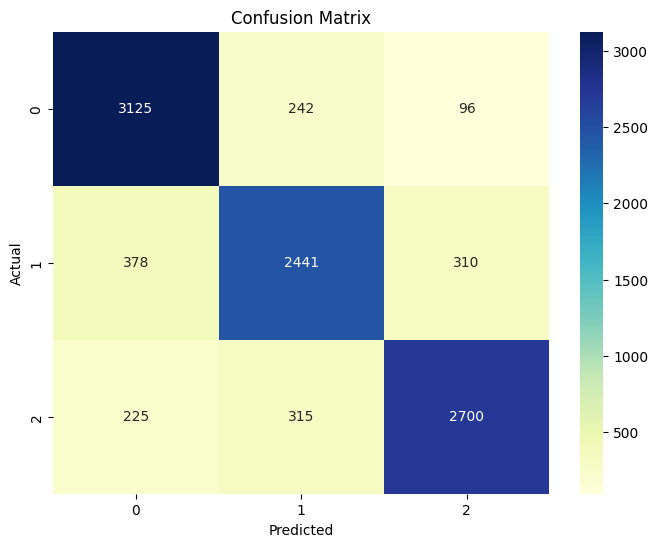

In [77]:
print("Bert + Roberta")
combined_preds = np.vstack([all_preds1[:-1], all_preds2[:-1]])
majority_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x)), axis=0, arr=combined_preds)
test_preds = majority_vote.tolist()

# Accuracy
test_accuracy = accuracy_score(test_labels, test_preds)
print("Ensemble Test Accuracy : {:.2f}%".format(test_accuracy * 100))

# F1 Score
f1 = f1_score(test_labels, test_preds, average='weighted')
print("Ensemble F1 Score : {:.2f}%".format(f1 * 100))

# Recall
recall = recall_score(test_labels, test_preds, average='weighted')
print("Ensemble Recall Score : {:.2f}%".format(recall * 100))

# Classification Report
print("Classification Report:")
print(classification_report(test_labels, test_preds))

# Confusion matrix
conf_matrix = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGnBu', xticklabels=np.unique(test_labels), yticklabels=np.unique(test_labels))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Bert + Alberta
Ensemble Test Accuracy : 82.82%
Ensemble F1 Score : 82.79%
Ensemble Recall Score : 82.82%
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      3463
           1       0.79      0.79      0.79      3129
           2       0.86      0.81      0.83      3240

    accuracy                           0.83      9832
   macro avg       0.83      0.83      0.83      9832
weighted avg       0.83      0.83      0.83      9832



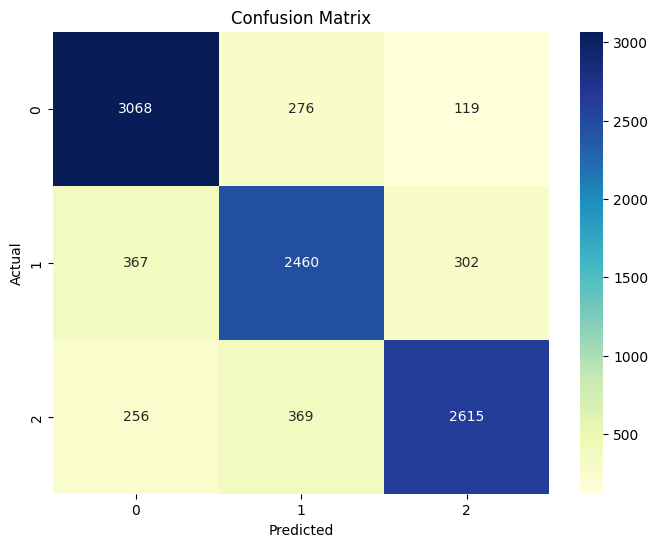

In [78]:
print("Bert + Alberta")
combined_preds = np.vstack([all_preds1[:-1], all_preds3[:-1]])
majority_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x)), axis=0, arr=combined_preds)
test_preds = majority_vote.tolist()

# Accuracy
test_accuracy = accuracy_score(test_labels, test_preds)
print("Ensemble Test Accuracy : {:.2f}%".format(test_accuracy * 100))

# F1 Score
f1 = f1_score(test_labels, test_preds, average='weighted')
print("Ensemble F1 Score : {:.2f}%".format(f1 * 100))

# Recall
recall = recall_score(test_labels, test_preds, average='weighted')
print("Ensemble Recall Score : {:.2f}%".format(recall * 100))

# Classification Report
print("Classification Report:")
print(classification_report(test_labels, test_preds))

# Confusion matrix
conf_matrix = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGnBu', xticklabels=np.unique(test_labels), yticklabels=np.unique(test_labels))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


# **Ensemble + Avg**

Bert + Roberta + Alberta
Ensemble + Average Test Accuracy : 85.20%
Ensemble + Average F1 Score : 85.19%
Ensemble + Average Recall Score : 85.20%


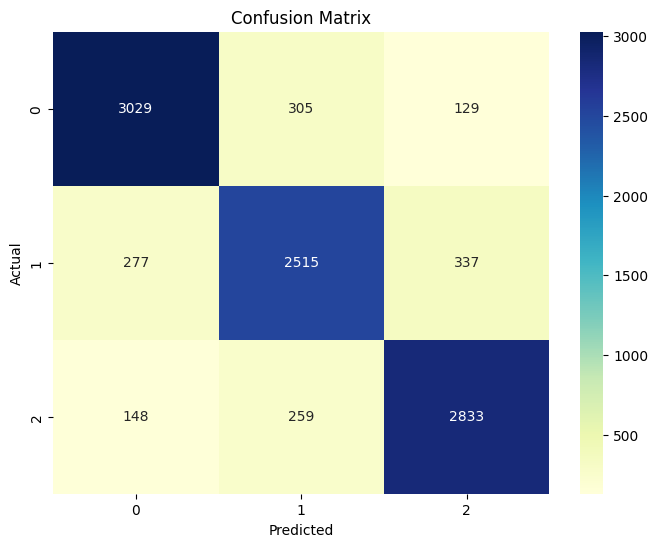

In [79]:
print("Bert + Roberta + Alberta")
combined_preds = np.vstack([all_preds1, all_preds2, all_preds3])
majority_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x)), axis=0, arr=combined_preds)
test_preds = majority_vote.tolist()

# Accuracy
test_accuracy = accuracy_score(test_labels, test_preds)
print("Ensemble + Average Test Accuracy : {:.2f}%".format(test_accuracy * 100))

# F1 Score
f1 = f1_score(test_labels, test_preds, average='weighted')
print("Ensemble + Average F1 Score : {:.2f}%".format(f1 * 100))

# Recall
recall = recall_score(test_labels, test_preds, average='weighted')
print("Ensemble + Average Recall Score : {:.2f}%".format(recall * 100))

# Confusion matrix
conf_matrix = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGnBu', xticklabels=np.unique(test_labels), yticklabels=np.unique(test_labels))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Roberta + Alberta
Ensemble + Average Test Accuracy : 85.41%
Ensemble + Average F1 Score : 85.40%
Ensemble + Average Recall Score : 85.41%


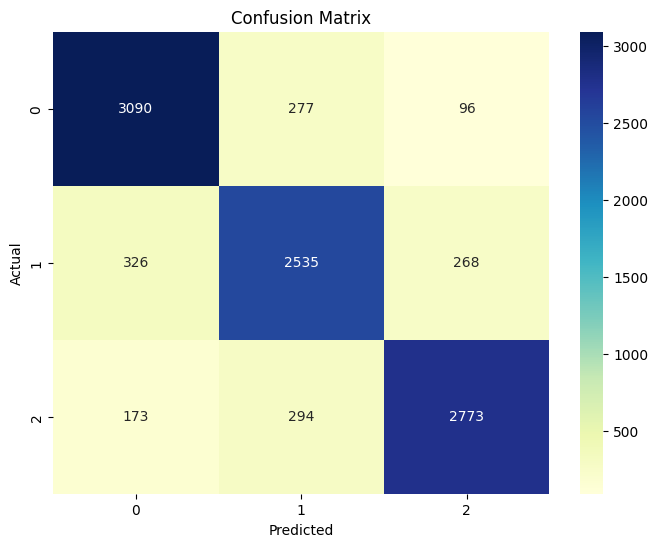

In [80]:
print("Roberta + Alberta")
combined_preds = np.vstack([all_preds2, all_preds3])
majority_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x)), axis=0, arr=combined_preds)
test_preds = majority_vote.tolist()

# Accuracy
test_accuracy = accuracy_score(test_labels, test_preds)
print("Ensemble + Average Test Accuracy : {:.2f}%".format(test_accuracy * 100))

# F1 Score
f1 = f1_score(test_labels, test_preds, average='weighted')
print("Ensemble + Average F1 Score : {:.2f}%".format(f1 * 100))

# Recall
recall = recall_score(test_labels, test_preds, average='weighted')
print("Ensemble + Average Recall Score : {:.2f}%".format(recall * 100))

# Confusion matrix
conf_matrix = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGnBu', xticklabels=np.unique(test_labels), yticklabels=np.unique(test_labels))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Bert + Roberta
Ensemble + Average Test Accuracy : 85.02%
Ensemble + Average F1 Score : 85.00%
Ensemble + Average Recall Score : 85.02%


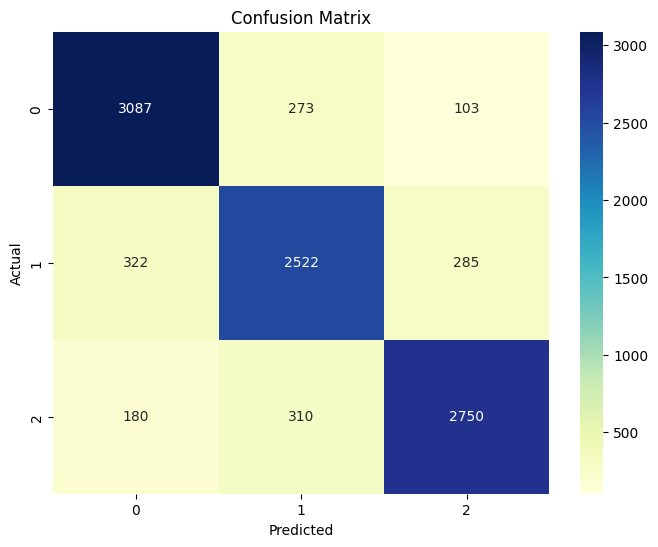

In [81]:
print("Bert + Roberta")
combined_preds = np.vstack([all_preds1, all_preds2])
majority_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x)), axis=0, arr=combined_preds)
test_preds = majority_vote.tolist()

# Accuracy
test_accuracy = accuracy_score(test_labels, test_preds)
print("Ensemble + Average Test Accuracy : {:.2f}%".format(test_accuracy * 100))

# F1 Score
f1 = f1_score(test_labels, test_preds, average='weighted')
print("Ensemble + Average F1 Score : {:.2f}%".format(f1 * 100))

# Recall
recall = recall_score(test_labels, test_preds, average='weighted')
print("Ensemble + Average Recall Score : {:.2f}%".format(recall * 100))

# Confusion matrix
conf_matrix = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGnBu', xticklabels=np.unique(test_labels), yticklabels=np.unique(test_labels))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Bert + Alberta
Ensemble + Average Test Accuracy : 83.50%
Ensemble + Average F1 Score : 83.50%
Ensemble + Average Recall Score : 83.50%


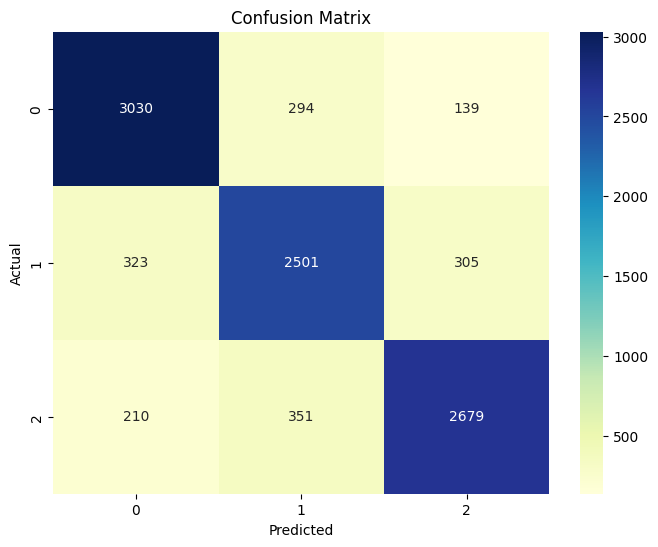

In [82]:
print("Bert + Alberta")
combined_preds = np.vstack([all_preds1, all_preds3])
majority_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x)), axis=0, arr=combined_preds)
test_preds = majority_vote.tolist()

# Accuracy
test_accuracy = accuracy_score(test_labels, test_preds)
print("Ensemble + Average Test Accuracy : {:.2f}%".format(test_accuracy * 100))

# F1 Score
f1 = f1_score(test_labels, test_preds, average='weighted')
print("Ensemble + Average F1 Score : {:.2f}%".format(f1 * 100))

# Recall
recall = recall_score(test_labels, test_preds, average='weighted')
print("Ensemble + Average Recall Score : {:.2f}%".format(recall * 100))

# Confusion matrix
conf_matrix = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGnBu', xticklabels=np.unique(test_labels), yticklabels=np.unique(test_labels))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
torch.save(model1, "BERT.pth")
torch.save(model2, "ROBERTA.pth")
torch.save(model3, "ALBERTA.pth")

In [ ]:
torch.save(model1, "BERT_final.pth")
torch.save(model2, "ROBERTA_final.pth")
torch.save(model3, "ALBERTA_final.pth")

In [ ]:
torch.save(model1.state_dict(), 'model1_state_dict.pth')